MSC 11-2022

# Spectral Analysis

- [**Imports**](#Imports)
- [**Introduction**](#Introduction)
- [**Mathematics**](#Mathematics)
    - [**Random Processes**](#Random-Processes)
    - [**Mean & Correlation Functions**](#Mean-&-Correlation-Functions)
    - [**Stationary Random Processes**](#Stationary-Random-Processes)
    - [**Power Spectral Density**](#Power-Spectral-Density)
    - [<b><font color='seagreen'>A Cautionary Example</b></font>](#A-Cautionary-Example)
    - [**Stationarity Tests**](#Stationarity-Tests)
- [**PSDs in Openseize**](#PSDs-in-Openseize)
- [**STFT & Spectrograms**](#STFT-&-Spectrograms)
- [**References**](#References)

## Imports

In [1]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from openseize import producer
from openseize.io.edf import Reader
from openseize import demos
from openseize.spectra import estimators

## Introduction

In the Fourier Transform demo, we explored how the Discrete Fourier Transform (DFT) takes a sequence from the time domain space and maps it to a new sequence in the frequency domain space. This method of spectral analysis is fine for deterministic signals like sines and cosines but is not appropriate for random signals. The DFT of a random signal is itself random. This means that the DFT will vary from one experiment to the next.
<br>
&emsp; This tutorial will present two methods for exploring the spectral content of discrete random signals. To determine which method to use, the researcher will need to answer this key question; <b><i>Is the random signal whose frequency content I wish to know stationary?</i></b>. To understand why this question is important, we'll start this demo by defining a random process and work our way towards stationarity. It is strongly encouraged that all readers who wish to perform spectral analysis carefully consider the following mathematics discussion.

## Mathematics

### Random Processes

A discrete-time random process is a collection of random variables $X_1, X_2, X_3, ...$ that are usually indexed by time. Formally a random process is written as:
<br>
<br>
<p style="text-align: center;">
    $
    \{X[n], \ n \in \mathbb{Z}\} \quad (1)
    $ 
</p>
<br>
<br>

#### Lets plot a simple random process $\{X[n], \ n=0, 1, 2, ...\}$ and each X[n] is ~ Normal(1,1).

In [4]:
def gaussian_rp(size, seed=None):
    """Returns a random process with size elements using a random seed."""
    
    rng = np.random.default_rng(seed)
    return rng.normal(1,1, size=size)

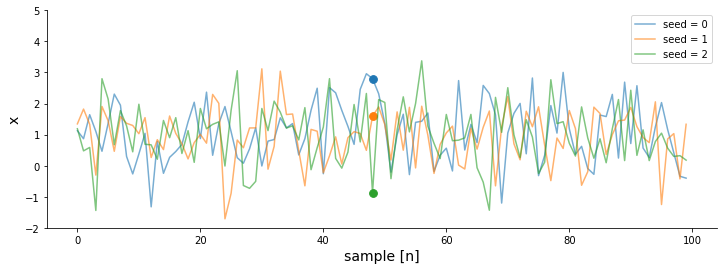

In [31]:
# create three 100 element "realizations" of our random process using different 
# random seeds
seeds = np.arange(3)
x = [gaussian_rp(100, s) for s in seeds]

# plot each realization 
fig, ax = plt.subplots(figsize=(12, 4))
for signal, seed in zip(x, seeds):
    ax.plot(signal, label='seed = {}'.format(seed), alpha=0.6)

#configure the plot
ax.set_xlabel('sample [n]', fontsize=14)
ax.set_ylabel('x', fontsize=14)
ax.set_ylim([-2, 5])
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc='upper right')

# plot the 48th element for each realization
ax.scatter(48, x[0][48], s=60)
ax.scatter(48, x[1][48], s=60)
ax.scatter(48, x[2][48], s=60)

plt.show()

For each random seed we get a unique path called the <b>sample path or realization of the random process</b>. Each point in each path is a random variable. We have plotted the 48th sample random variable for each realization as a colored dot. It is important to note that each sample path drew random variables from the same probability distrubution -- the Normal(1,1) distribution. This is not required, <b>the random process that generates each random variable in a sample path or realization does not need to come from the same distribution.</b> We are getting close to defining stationarity but before we do that, lets examine properties of these sample paths.In particular their expected values and their correlation functions.

### Mean & Correlation Functions

The mean of a random process is defined as:
<br>
<br>
<p style="text-align: center;">
    $
    \mu_X[n] = E\{X[n]\} \quad (2)
    $ 
</p>
<br>
<br>

Be careful, this is not the mean value of a sample path. That would be just a constant number. No this is a mean function. At each index n we compute the expected value of X[n]. In our case above, the expected value is E[Normal(1,1)] which is 1. So $\mu_X[n] = 1$ at each n. Another way to think about this is to generate many many sample paths and at each index average the random variables of each sample path at that index. This is the mean function. Formally, we define it as:
<br>
<br>
<p style="text-align: center;">
    $
    \mu_X[n] = E\{X[n]\} = \sum \limits_{n=-\infty}^\infty P(X[n]) X[n] \quad (3)
    $ 
</p>
<br>
<br>

Technical note, we have the sum from $-\infty$ to $\infty$. Thats no problem for EEGs where the samples run from 0 to some finite number N because we just set the probability $P(X[n])$ to be 0 everywhere except $n \in [0, N]$. 

The mean function gives us the expected value of X[n] at sample n but it does not tell us how the samples in a sample path are related. That is, given index p and index q in a sample path is their a relationship between X[p] and X[q]? The autocorrelation function tells us how samples in a sample path are related. The autocorrelation, or simply correlation function, is defined as:
<br>
<br>
<p style="text-align: center;">
    $
    R_X(p, q) = E\{X[p]X[q]\} \quad \textrm{for} \quad p,q \in [0, N] \quad (4)
    $ 
</p>
<br>
<br>
And the autocovariance, more simply called the covariance, is defined as:
<p style="text-align: center;">
    $
    C_X(p, q) = E\Bigl\{(X[p]-E\{X[p]\}) \ (X[q]-E\{X[p]\})\Bigr\} \quad \textrm{for} \quad p,q \in [0, N] \quad (5)
    $ 

Interpreting $C_X$, when X[p] and X[q] are both large compared to their means, $C_X$ will be positive. Conversely, when both are large but negative, $C_X$ is again positive. If X[p] is near its mean then no matter what X[q] is the covariance will be small. <b>In summary, the covariance tracks how X[p] and X[q] move together.</b>  

### Stationary Random Processes

In our random process example, we knew that each random variable along a a single sample path came from the same normal distribution. Mathematicians refer to this as <b>Strict-Sense Stationary</b>. In terms of the joint probability distribution function P, of two sample indices p and q, we can write this as: 
<br>
<br>
<p style="text-align: center;">
    $
    P(X[p], X[q]) = P(X[p+\Delta], X[q+\Delta]) \quad \textrm{for all} \quad p, q, \Delta \in [0,N] \quad (6)
    $ 
</p>
<br>
<br>

In words, a time shift of two points in a random process does not change the processes joint statistical properties. The joint PDF is the same under translation. This property defines Strict Sense Stationary. For EEG data, we do not know if such a distribution exist nor if this distribution changes across the sample indices. However, there is a weaker form of stationarity called <b>Weak or Wide-Sense Stationary</b>. This will give us a practical definition of stationarity without requiring us to know the PDF.